[*********************100%***********************]  3 of 3 completed


Data found

Data for ['NVDA', 'AAPL', 'MSFT'] downloaded successfully.


Running strategy for NVDA...


Running strategy for AAPL...


Running strategy for MSFT...


Plotting the results...['NVDA', 'AAPL', 'MSFT']



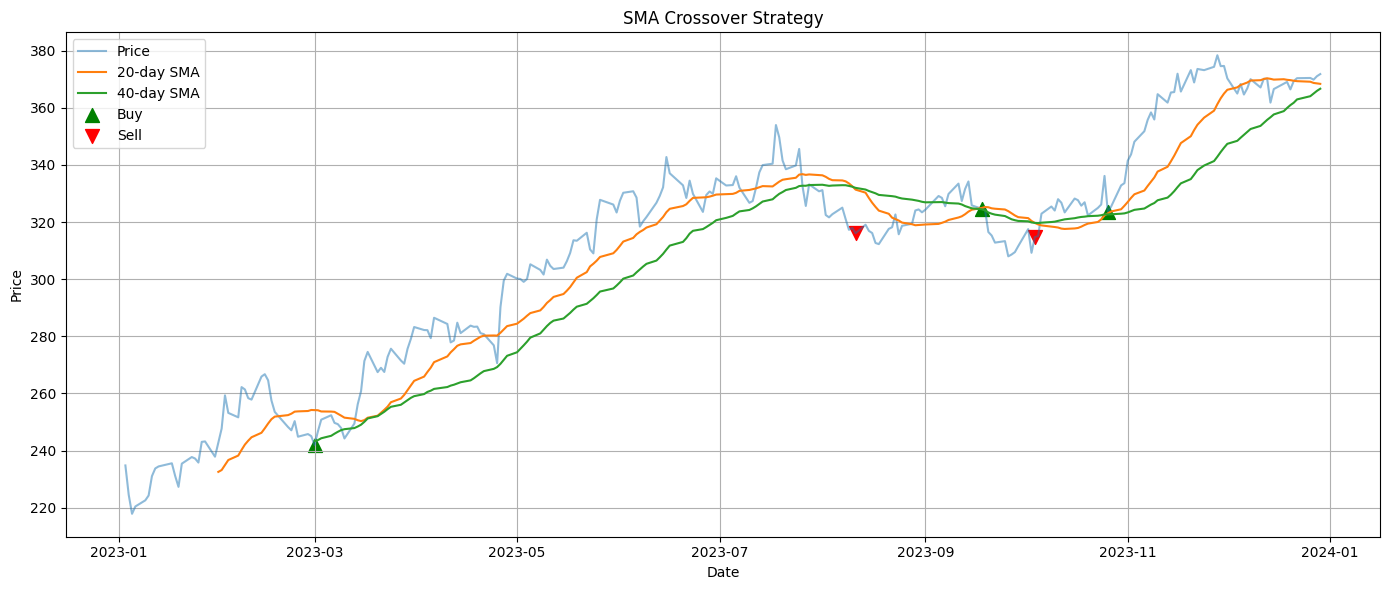

          Date       Price  Short SMA (20)  Long SMA (40)  Shares Bought  \
39  2023-03-01  241.970291      254.179900     243.367815            100   
152 2023-08-11  316.094879      331.368356     331.983542              0   
177 2023-09-18  324.707611      324.942967     324.481283            100   
189 2023-10-04  314.741211      319.709615     319.723534              0   
205 2023-10-26  323.553101      323.032581     322.677340            100   

     Shares Sold  Signal  Portfolio Value      Profit  Trade Profit  
39             0       1    100000.000000    0.000000      0.000000  
152          100      -1    107412.458801 -189.053345   -189.053345  
177            0       1    107412.458801    0.000000      0.000000  
189          100      -1    106415.818787  549.630737    549.630737  
205            0       1    106415.818787    0.000000      0.000000  

Summary of trades for ['NVDA', 'AAPL', 'MSFT']:


Total Profit: $360.58
Buy Trades: 3
Sell Trades: 2
Total Realized Profit

In [ ]:
# This script implements a simple trading strategy using Simple Moving Averages (SMA) to generate buy/sell signals.
import yfinance as yf
import pandas as pd
import sys
import matplotlib.pyplot as plt
#Ignore FutureWarnings from pandas
# This is to avoid warnings about future changes in pandas behavior that may not affect the current code
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# 1. Download historical stock data for any company in 2023

tickers = input("Enter ticker symbols separated by commas (e.g., AAPL,MSFT): ").upper().split(',')
try:
    data = yf.download(tickers, start="2023-01-01", end="2023-12-31")
    if not data.empty:
        print("Data found")
    else:
        sys.exit("No data found for the ticker symbol.")

except Exception as e:
    print("Error:", e)

print(f"\nData for {tickers} downloaded successfully.\n")

# Loop over each ticker
for ticker in tickers:
    print(f"\nRunning strategy for {ticker}...\n")
    prices = data['Close'][ticker].squeeze() 
    short_window_size = int(input(f"Enter the window size for {ticker} short-term SMA: "))
    long_window_size = int(input(f"Enter the window size for {ticker} long-term SMA: "))

# 2. Calculate short-term and long-term SMAs User input
short_sma = prices.rolling(window=short_window_size).mean()
long_sma = prices.rolling(window=long_window_size).mean()



# 3. Generate trading signals based on SMA crossover
signals = ['Hold']  # no signal on first day

for i in range(1, len(prices)):
    if short_sma.iloc[i] > long_sma.iloc[i] and short_sma.iloc[i-1] <= long_sma.iloc[i-1]:
        signals.append('Buy')
    elif short_sma.iloc[i] < long_sma.iloc[i] and short_sma.iloc[i-1] >= long_sma.iloc[i-1]:
        signals.append('Sell')
    else:
        signals.append('Hold')


# 4. Simulate portfolio with $10,000 cash, buy/sell 1 share per signal
shares = 0
cash = 100000  # starting capital
portfolio_values = []
shares_bought = []
shares_sold = []

for i in range(len(prices)):
    if short_sma[i] > long_sma[i] and shares == 0:
        shares = 100
        cost = shares * prices[i]
        cash -= cost
        shares_bought.append(shares)
        shares_sold.append(0)
    elif short_sma[i] < long_sma[i] and shares > 0:
        cash += shares * prices[i]
        shares_bought.append(0)
        shares_sold.append(shares)
        shares = 0
    else:
        shares_bought.append(0)
        shares_sold.append(0)
    
    portfolio_value = cash + shares * prices[i]
    portfolio_values.append(portfolio_value)

short_col = f'Short SMA ({short_window_size})'
long_col = f'Long SMA ({long_window_size})'


# 5. Create a summary DataFrame with all info
summary = pd.DataFrame({
    'Date': prices.index,
    'Price': prices.values,
    short_col: short_sma.values,
    long_col: long_sma.values,
    'Shares Bought': shares_bought,
    'Shares Sold': shares_sold,
    'Signal': signals,
    'Portfolio Value': portfolio_values
})

summary['Signal'] = 0  # default hold
summary.loc[summary['Shares Bought'] > 0, 'Signal'] = 1  # Buy
summary.loc[summary['Shares Sold'] > 0, 'Signal'] = -1  # Sell
summary['Profit'] = summary['Portfolio Value'].diff().fillna(0)
summary['Trade Profit'] = summary['Profit'].where(summary['Signal'] != 0, 0)
total_profit = summary['Trade Profit'].sum()
buy_trades = summary['Signal'].value_counts().get(1, 0)
sell_trades = summary['Signal'].value_counts().get(-1, 0)

# 6. Calculate total realized profit from trades
# This will sum the profits from each buy-sell pair
trade_profits = []
buy_price = 0
buy_shares = 0
holding = False

for i in range(len(prices)):
    # When buying
    if summary.loc[i, 'Signal'] == 1:
        buy_price = summary.loc[i, 'Price']
        buy_shares = summary.loc[i, 'Shares Bought']
        holding = True

    # When selling and currently holding shares
    elif summary.loc[i, 'Signal'] == -1 and holding:
        sell_price = summary.loc[i, 'Price']
        sell_shares = summary.loc[i, 'Shares Sold']
        profit = (sell_price * sell_shares) - (buy_price * buy_shares)
        trade_profits.append(profit)
        holding = False

# Check if holding shares at the end of the period
if holding:
    # Sell all remaining shares at the last price
    sell_price = summary.loc[len(summary) - 1, 'Price']
    sell_shares = buy_shares  # shares held
    profit = (sell_price * sell_shares) - (buy_price * buy_shares)
    trade_profits.append(profit)
    holding = False


#Plotting the results
print(f"\nPlotting the results...{tickers}\n")

plt.figure(figsize=(14, 6))
plt.plot(summary['Date'], summary['Price'], label='Price', alpha=0.5)
plt.plot(summary['Date'], summary[short_col], label=f'{short_window_size}-day SMA')
plt.plot(summary['Date'], summary[long_col], label=f'{long_window_size}-day SMA')



# Plot Buy/Sell signals
buy_signals = summary[summary['Signal'] == 1]
sell_signals = summary[summary['Signal'] == -1]
plt.scatter(buy_signals['Date'], buy_signals['Price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_signals['Date'], sell_signals['Price'], marker='v', color='red', label='Sell', s=100)

plt.legend()
plt.title("SMA Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Sum all trade profits
total_realized_profit = sum(trade_profits)


#Summary of trades

print(summary[summary['Signal'] != 0])

print(f"\nSummary of trades for {tickers}:\n")
print(f"\nTotal Profit: ${total_profit:.2f}")
print(f"Buy Trades: {buy_trades}")
print(f"Sell Trades: {sell_trades}")
print(f"Total Realized Profit from Trades: ${total_realized_profit:.2f}\n")